In [137]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')

# Customize the default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'


house_df_org = pd.read_csv('csv/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [138]:
print(house_df.shape)

(1460, 81)


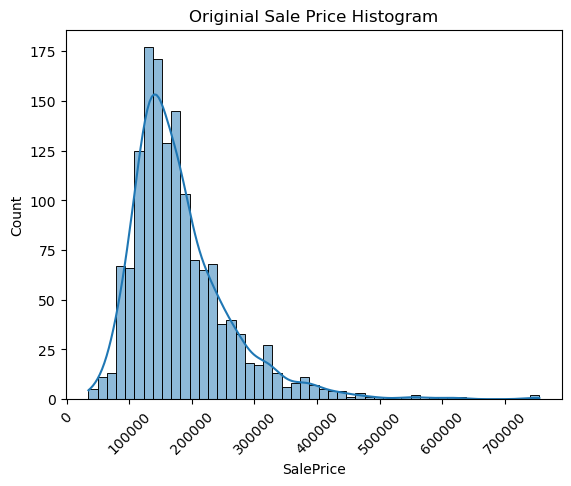

In [139]:
#타깃 값이 정규분포인지 확인
plt.title('Originial Sale Price Histogram')
plt.xticks(rotation = 45)
sns.histplot(house_df['SalePrice'],kde = True)
plt.show()


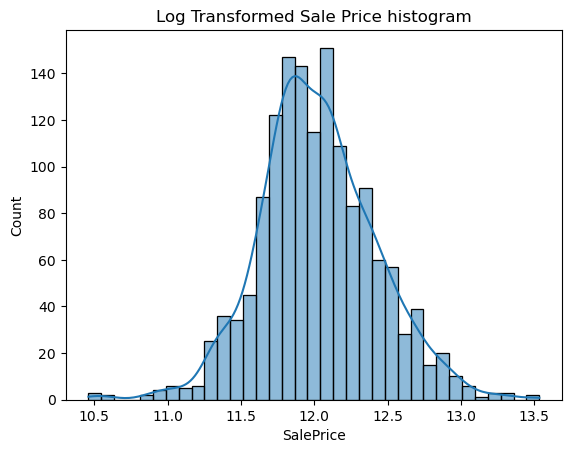

In [140]:
#정규분포로 변환
plt.title('Log Transformed Sale Price histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde = True)
plt.show()

In [141]:
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [142]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1,inplace = True)
house_df.fillna(house_df.mean(),inplace = True)
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0] 
print('##null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

##null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [143]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('##null 피처의 타입 :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
##null 피처의 타입 :
 Series([], dtype: object)


In [144]:
def get_rmse(model):
    pred =model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [145]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1318957657915435, 0.1275084633405304, 0.17628250556471406]

In [146]:
def get_top_bottom_coef(model, n=10):
    #coef 속성을 기반으로 Series 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    #상위 10개, 하위 10개의 회귀계수
    coef_high = coef.sort_values(ascending = False).head(n)
    coef_low = coef.sort_values(ascending = False).tail(n)
    return coef_high, coef_low

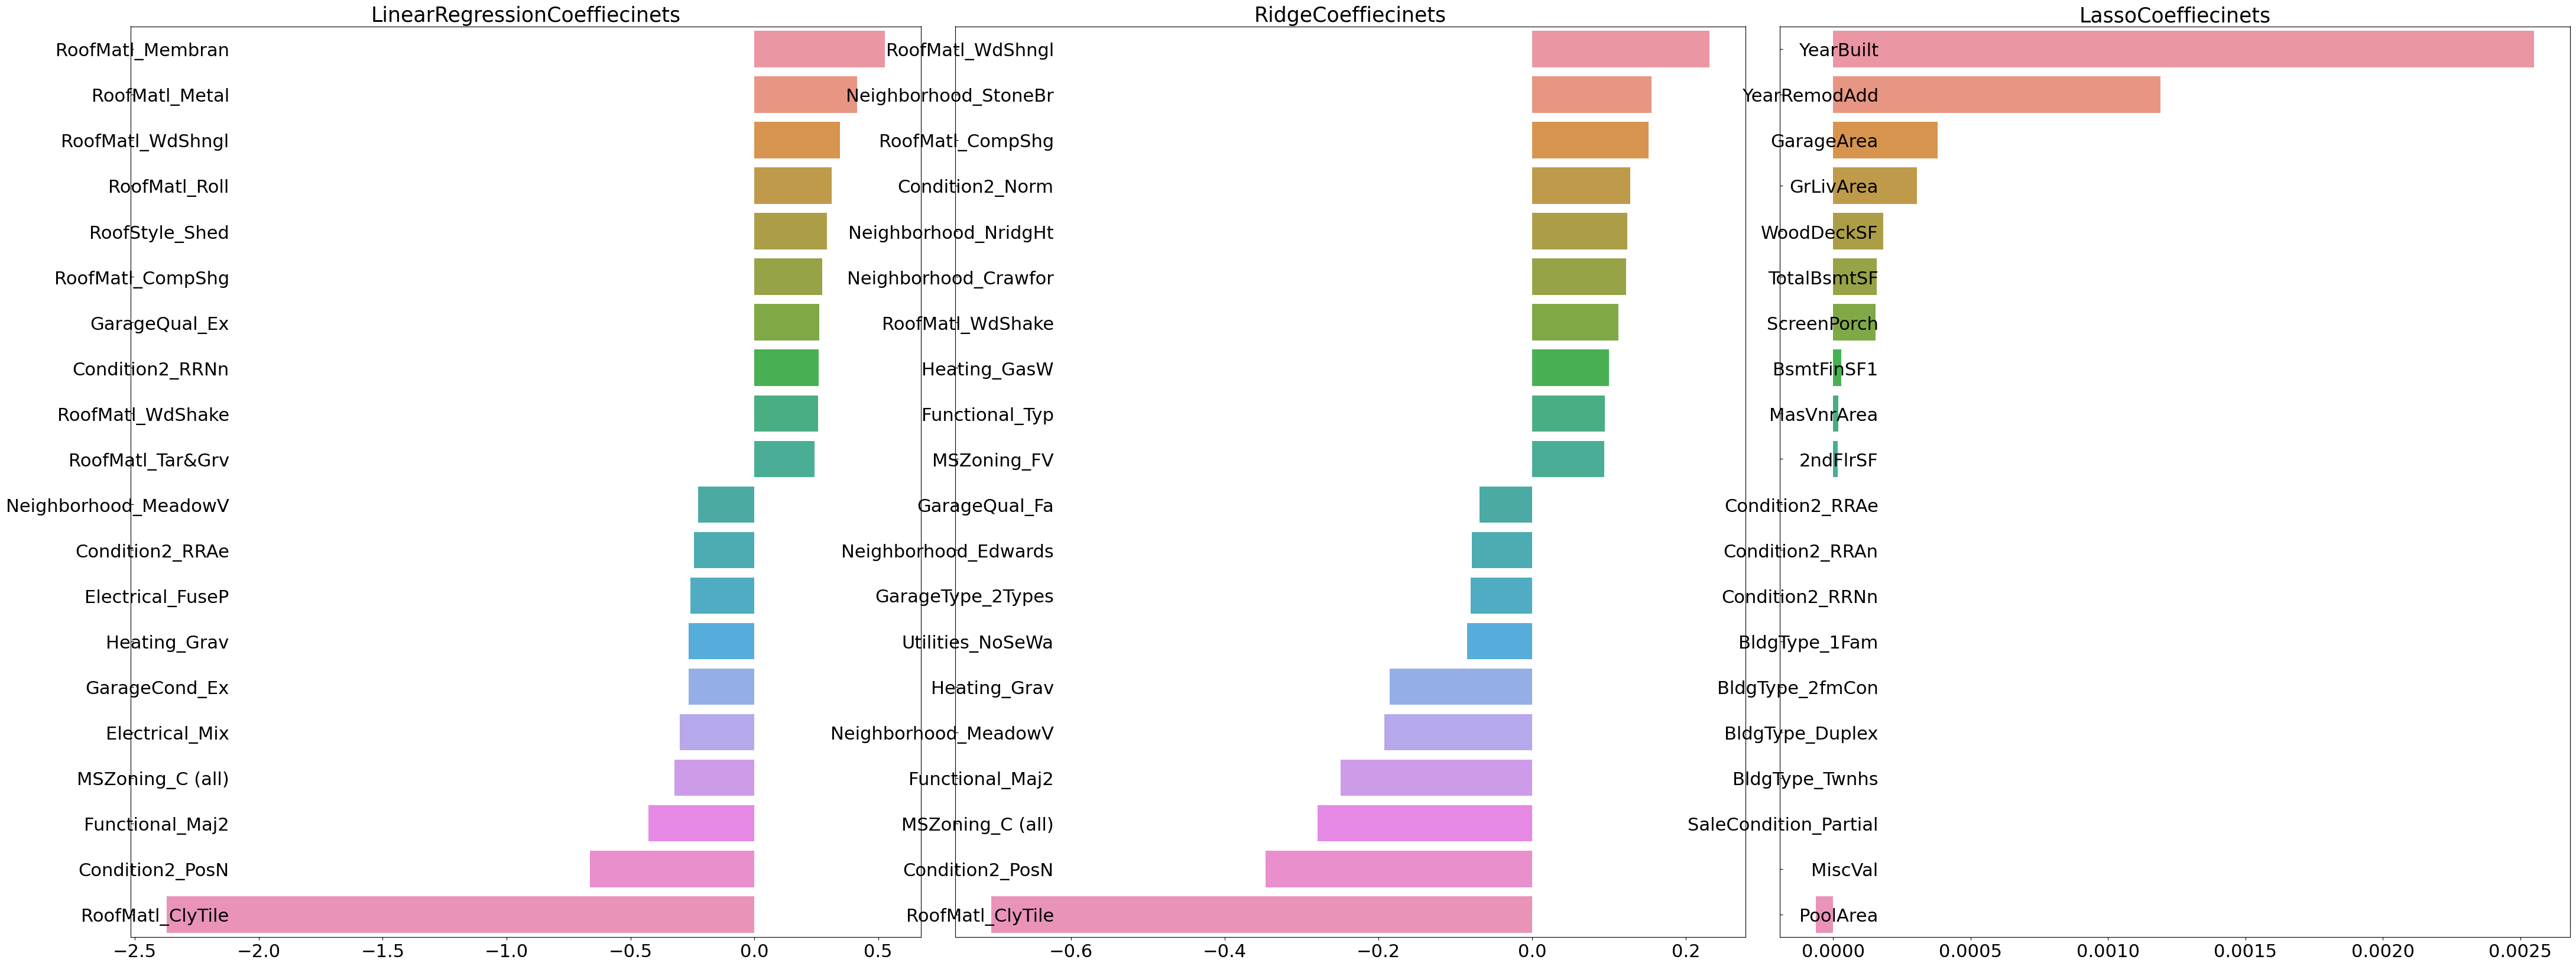

In [147]:
def visualize_coefficient(models):
    #3개 회귀모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(42,16), nrows = 1, ncols = 3)
    fig.tight_layout()
    #입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecinets', size = 25)
        axs[i_num].tick_params(axis = 'y', direction='in', pad = -120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
            
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
        

In [148]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models: 
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring= 'neg_mean_squared_error', cv = 5))
        
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV RMSE 값: 0.198


In [149]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE:{1}, 최적 알파:{2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE:0.1418, 최적 알파:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE:0.142, 최적 알파:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


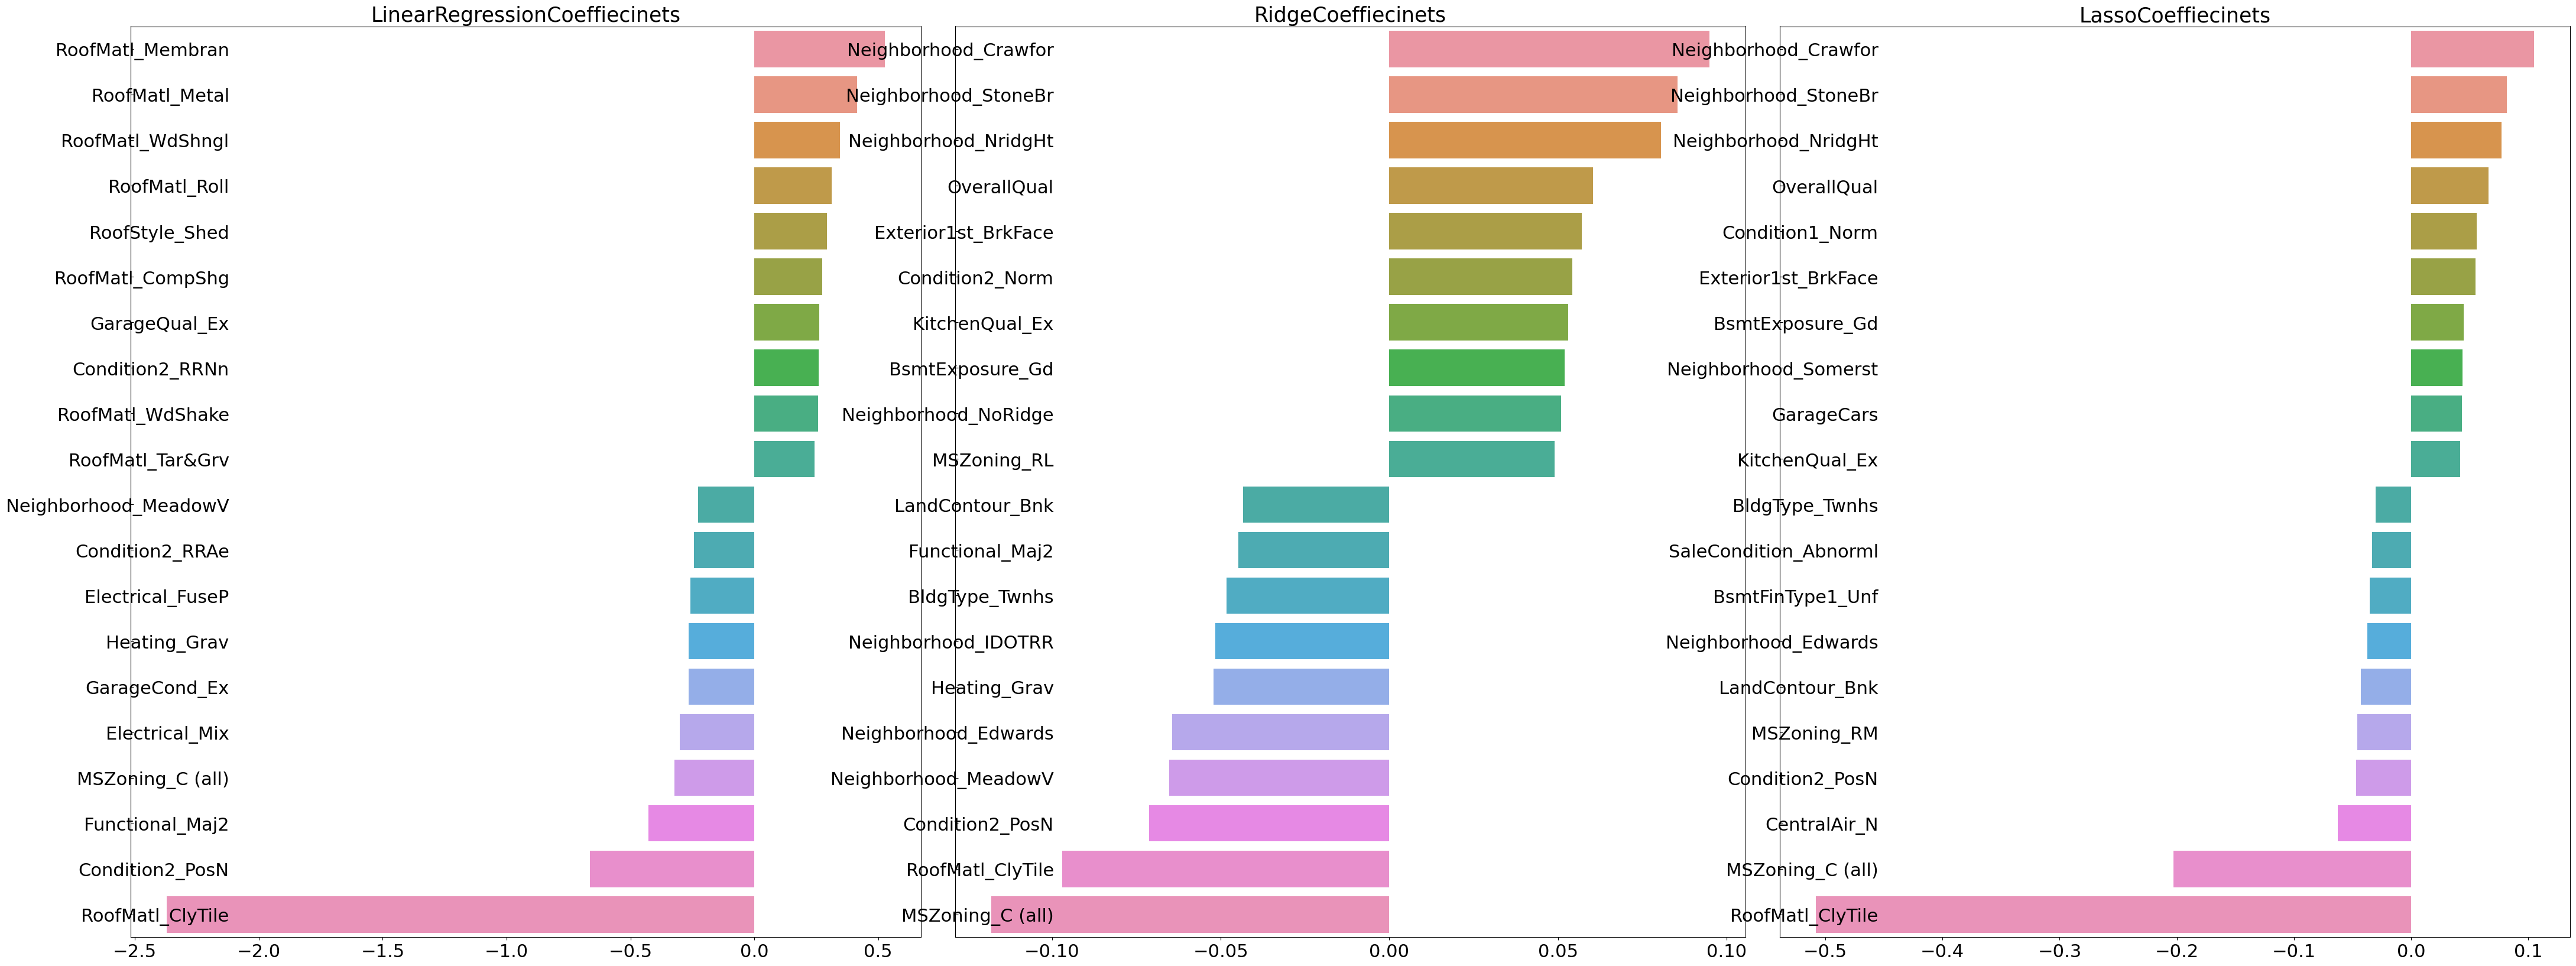

In [150]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha = 12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [151]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index

skew_features = house_df[features_index].apply(lambda x:skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [152]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [185]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice' , axis = 1, inplace = False)
X_train, X_test, y_train,  y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = {'alpha':[0.05, 0.1, 1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE:0.1275, 최적 알파:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE:0.1252, 최적 알파:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


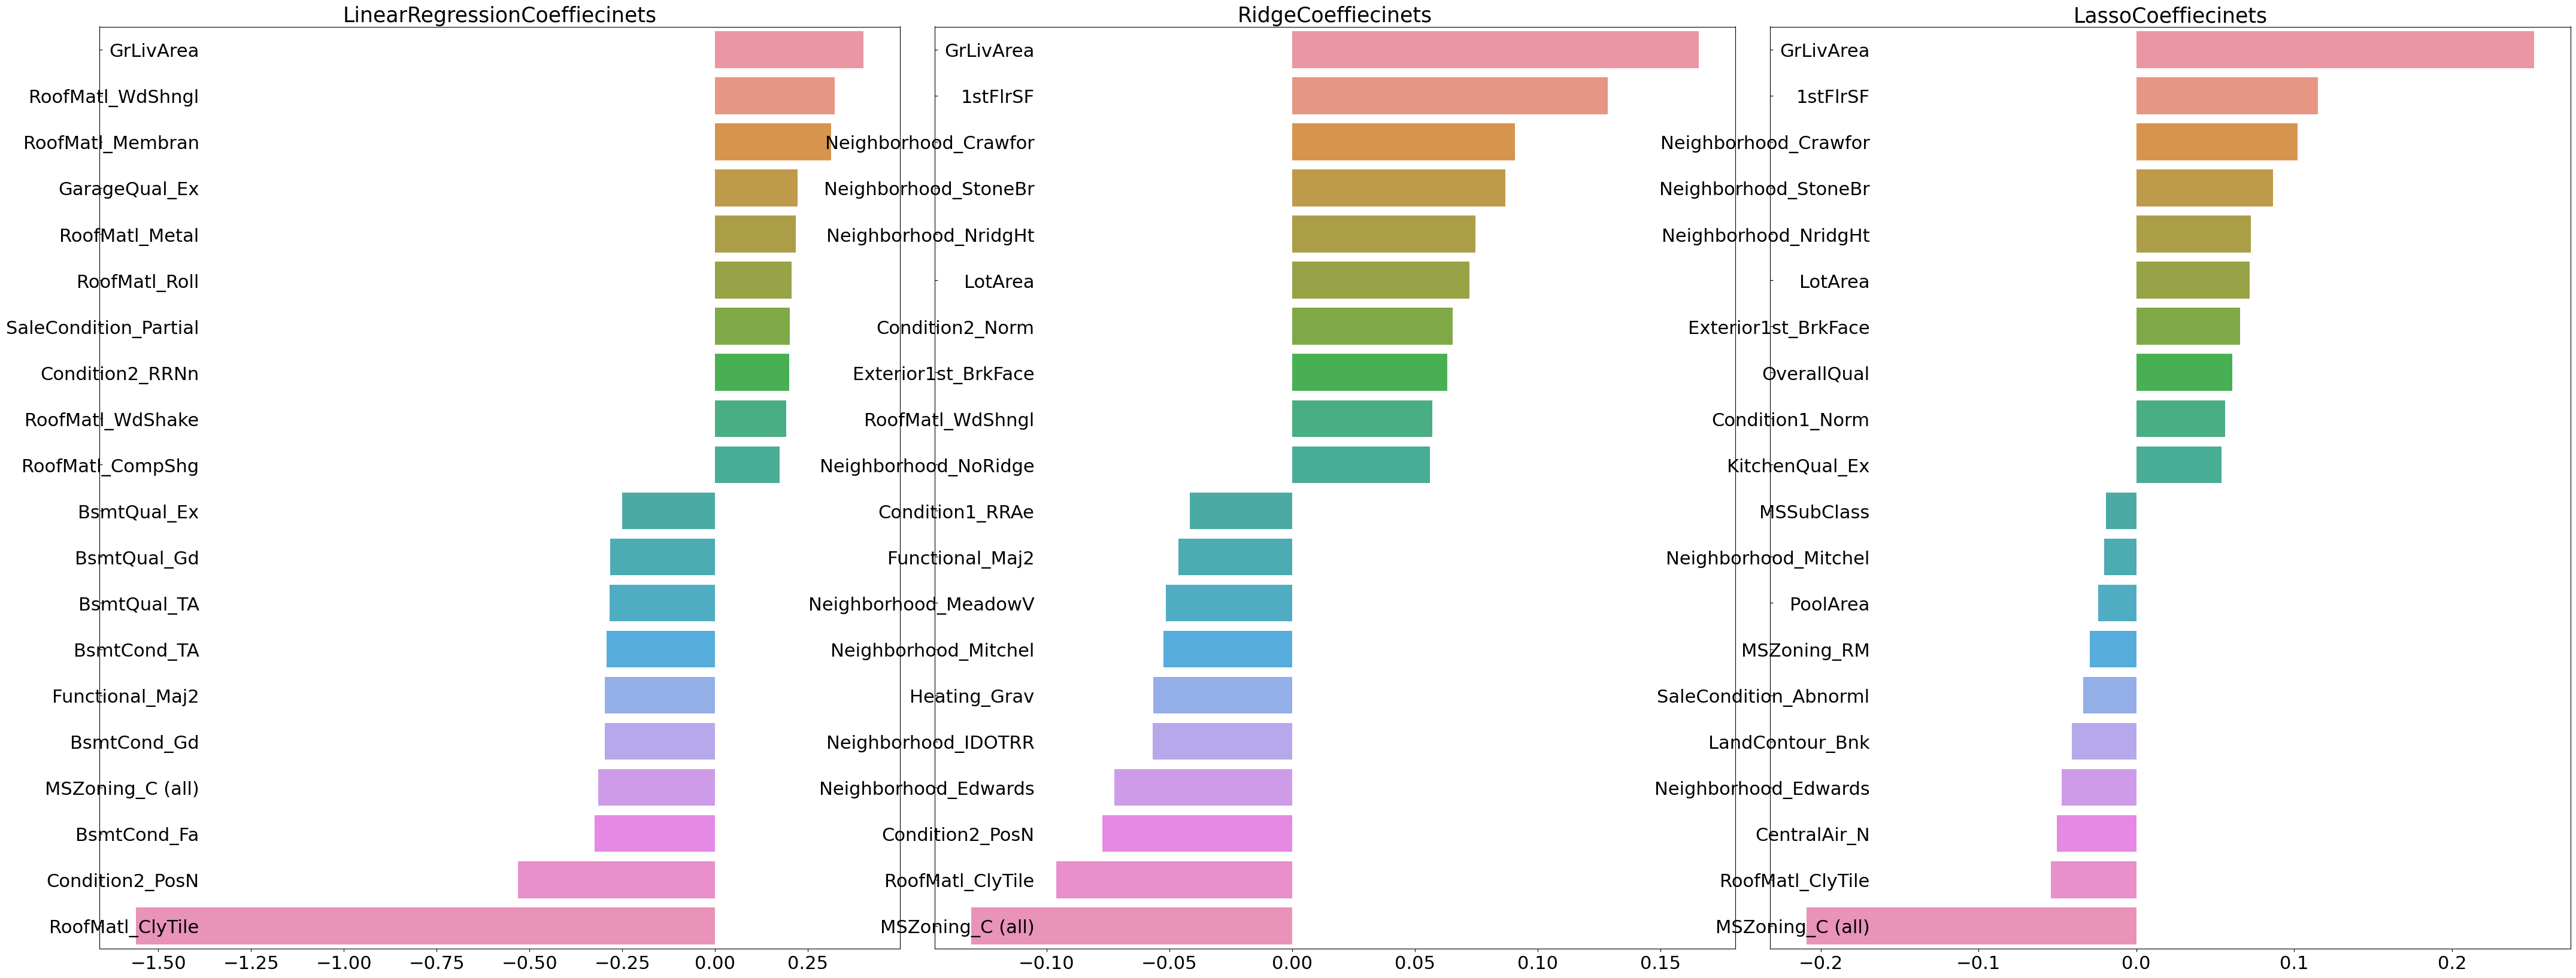

In [187]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

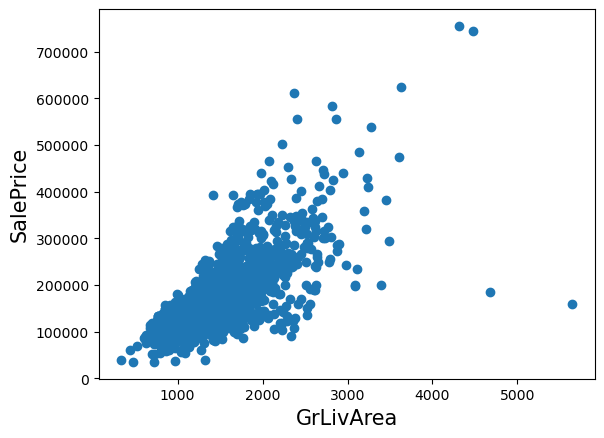

In [154]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize = 15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [155]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index: ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape: ', house_df_ohe.shape)

#이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis = 0, inplace = True)
print('이상치 삭제 후 house_df_ohe shape: ', house_df_ohe.shape)

이상치 레코드 index:  [ 523 1298]
이상치 삭제 전 house_df_ohe shape:  (1460, 271)
이상치 삭제 후 house_df_ohe shape:  (1458, 271)


In [157]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
X_train , X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = {'alpha':[0.05, 0.1, 1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE:0.1125, 최적 알파:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE:0.1122, 최적 알파:{'alpha': 0.001}


In [134]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge, Lasso

def print_best_params(model, params, X, y):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV RMSE value: {1}, optimal alpha: {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))


ridge_reg = Ridge()
lasso_reg = Lasso()


ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params, X_features, y_target)
print_best_params(lasso_reg, lasso_params, X_features, y_target)


Ridge 5 CV RMSE value: 0.1418, optimal alpha: {'alpha': 12}
Lasso 5 CV RMSE value: 0.142, optimal alpha: {'alpha': 0.001}


In [160]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE:0.1171, 최적 알파:{'n_estimators': 1000}


In [162]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, 
                         subsample = 0.6, colsample_bytree = 0.4, reg_lambda =10, n_jobs = -1)

print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE:0.1163, 최적 알파:{'n_estimators': 1000}


In [165]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
#개별 모델의 학습
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470498
Ridge 모델의 RMSE: 0.10345177546603221
Lasso 모델의 RMSE: 0.1002417046089003


In [170]:
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, 
                         subsample = 0.6, colsample_bytree = 0.4, reg_lambda =10, n_jobs = -1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*ridge_pred + 0.5*lasso_pred
preds = {'최종 혼합': pred, 'XGBM': xgb_pred, 'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.1003444158752537
XGBM 모델의 RMSE: 0.10738295638346222
LGBM 모델의 RMSE: 0.10382510019327311


In [176]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits = n_folds, shuffle = False)
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)
        
    return train_fold_pred, test_pred_mean 

In [177]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작


In [183]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis = 1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis = 1)

meta_model_lasso = Lasso(alpha = 0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은: ', np.round(rmse,4))

스태킹 회귀 모델의 최종 RMSE 값은:  0.098
